## Проект "Прогнозирование заказов такси". Временные ряды

### Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

### Цель проекта
- Построить модель предсказания спроса на такси на следующий час


### Требования к работе модели
- Сделайте тестовую выборку размером 10% от исходных данных
- Обучите разные модели с различными гиперпараметрами
- RMSE на тестовой выборке должно быть не больше 48
- P.s.Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



from numpy.random import RandomState
rdm = RandomState(1234)

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_absolute_error as mae

In [2]:
!pip install catboost

In [3]:
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [4]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [5]:
data.shape

(26496, 1)

In [6]:
data.sample(5)

,num_orders
datetime,
2018-04-30 10:50:00,16
2018-08-31 00:50:00,51
2018-03-09 02:30:00,1
2018-05-14 18:30:00,14
2018-04-03 00:30:00,22


In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.duplicated().sum()

26415

In [10]:
data.isna().sum()

num_orders    0
dtype: int64

### Вывод после загрузки данны
Датасет не содержит дубликатов, типы данных верные, пропусков не обранужено. Есть некоторое количество аномальных значений в количестве заказов.Уберем их на последующих этапах предобработки из расчета, что если такси работает 10 часов в день и на заказ в стредем тратится 15 минут, то максиумум может быть 40 заказов в день. 

### Подготовка данных для работы моделей машиного обучения

In [11]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Ресемплирование данных по одному часу

In [12]:
data = data.resample('1H').sum()

In [13]:
print(data.index.is_monotonic)

True


In [14]:
data.isna().sum()

num_orders    0
dtype: int64

### Анализ трендов и сезонности

- decomposed.trend — тренд;
- decomposed.seasonal — сезонная составляющая;
- decomposed.resid — остаток декомпозиции.

### Анализ трендов

<AxesSubplot:xlabel='datetime'>

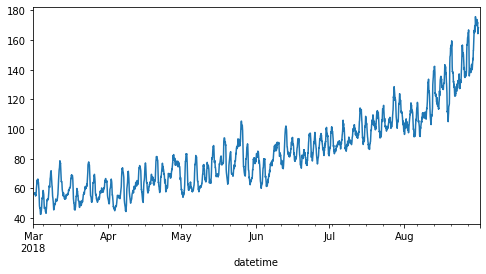

In [15]:
decomposed_trend = seasonal_decompose(data['num_orders'].resample('1H').sum())
 
plt.figure(figsize=(8, 4))
decomposed_trend.trend.plot(ax=plt.gca())

#### Вывод: наблюдается увеличение количества заказов такси в период с июня по конец августа

### Анализ сезонов

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='datetime'>

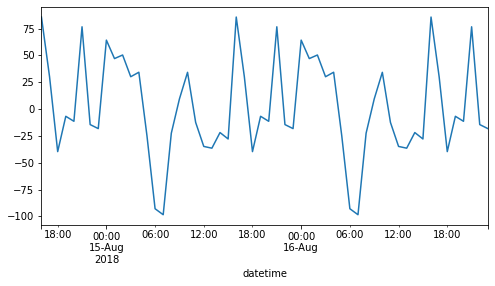

In [17]:
decomposed_seasonal = seasonal_decompose(data[4000:4056]['num_orders'].resample('1H').sum())
 
plt.figure(figsize=(8, 4))
decomposed_seasonal.seasonal.plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

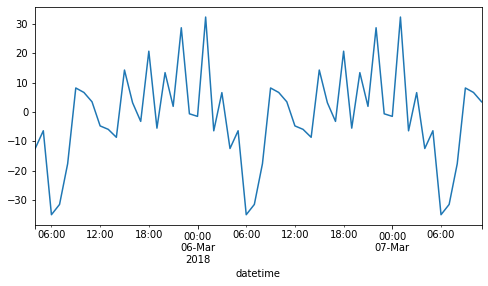

In [18]:
decomposed_seasonal = seasonal_decompose(data[100:156]['num_orders'].resample('1H').sum())
 
plt.figure(figsize=(8, 4))
decomposed_seasonal.seasonal.plot(ax=plt.gca())

сезонность - приросты относительно среднего уровня продаж.6 утра - минус тридцать продаж относительно сутокчного среднего, поэтому получаются отрицательные значения.

#### Вывод: наблюдается увеличение количества заказов такси еженедельно в течение всего временного периода датафрейма

### Анализ шума

<AxesSubplot:xlabel='datetime'>

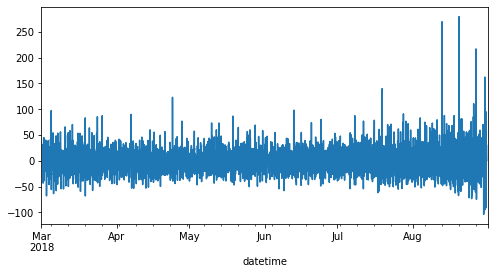

In [19]:
decomposed_resid = seasonal_decompose(data['num_orders'].resample('1H').sum())
 
plt.figure(figsize=(8, 4))
decomposed_resid.resid.plot(ax=plt.gca())

#### Вывод: шума в данных в по марту больше, чем в другие месяцы

### Поиск разности временного ряда 

AxesSubplot(0.125,0.125;0.775x0.755)


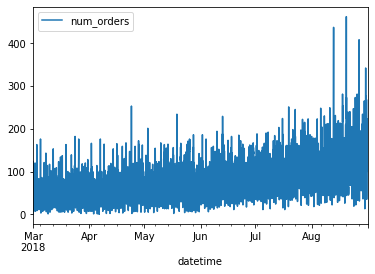

In [20]:
data_shift = data.shift(fill_value=0)
print(data_shift.plot())

### Создание признаков для прогнозирования

Представим как отдельные столбцы день недели, час, скользящее среднее и лаги

Рассмотриваем день недели, т.к. у нас еть недельная сезоннасть в заказах такси (график сезонов с ресемплированием по дням)

In [21]:
data['dayofweek'] = data.index.dayofweek

Также создадим признак по часу,т.к. в  задании требуется предсказание на 24 часа и в зависимоти от времени в сутках будет меняться количество заказов

In [22]:
data['hour'] = data.index.hour

Скользящее среднее как признак задаёт общий тренд временного ряда

In [23]:
data['rolling_mean'] = data['num_orders'].rolling(15).sum()

Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. Получим отстающие значения функцией shift()

In [24]:
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_3'] = data['num_orders'].shift(3)

Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - воалияли на сегоняшние.Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние
    
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда.

In [25]:
print(data.sample(10))

                     num_orders  dayofweek  hour  rolling_mean  lag_1  lag_2  \
datetime                                                                       
2018-08-26 01:00:00         156          6     1        2179.0  281.0  174.0   
2018-06-26 07:00:00          41          1     7        1126.0   39.0   17.0   
2018-08-27 22:00:00         173          0    22        2253.0  152.0   96.0   
2018-04-16 13:00:00          74          0    13        1138.0   52.0   81.0   
2018-06-22 14:00:00          89          4    14        1299.0   96.0   57.0   
2018-04-19 15:00:00          93          3    15         798.0   38.0   42.0   
2018-06-13 03:00:00         103          2     3        1741.0  229.0   97.0   
2018-06-04 01:00:00          69          0     1        1197.0  176.0  124.0   
2018-06-02 05:00:00          44          5     5        1351.0   95.0   85.0   
2018-03-03 04:00:00          44          5     4        1195.0   64.0   25.0   

                     lag_3  
datetime  

Сформируем функцию для выделения признаков в датасете

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()
    
make_features(data, 3, 8)
print(data.head())

                     num_orders  dayofweek  hour  rolling_mean  lag_1  lag_2  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0           NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1           NaN  124.0    NaN   
2018-03-01 02:00:00          71          3     2           NaN   85.0  124.0   
2018-03-01 03:00:00          66          3     3           NaN   71.0   85.0   
2018-03-01 04:00:00          43          3     4           NaN   66.0   71.0   

                     lag_3  
datetime                    
2018-03-01 00:00:00    NaN  
2018-03-01 01:00:00    NaN  
2018-03-01 02:00:00    NaN  
2018-03-01 03:00:00  124.0  
2018-03-01 04:00:00   85.0  


### Разделение на выборки

In [27]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print('Обучающая выборка:')
print(train)
print('Тестовая выборка:')
print(test) 

Обучающая выборка:
                     num_orders  dayofweek  hour  rolling_mean  lag_1  lag_2  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0           NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1           NaN  124.0    NaN   
2018-03-01 02:00:00          71          3     2           NaN   85.0  124.0   
2018-03-01 03:00:00          66          3     3           NaN   71.0   85.0   
2018-03-01 04:00:00          43          3     4           NaN   66.0   71.0   
...                         ...        ...   ...           ...    ...    ...   
2018-08-13 09:00:00         137          0     9       162.500   91.0   39.0   
2018-08-13 10:00:00         156          0    10       145.500  137.0   91.0   
2018-08-13 11:00:00         144          0    11       110.375  156.0  137.0   
2018-08-13 12:00:00          92          0    12       107.375  144.0  156.0   
2018-08-13 13:00:00  

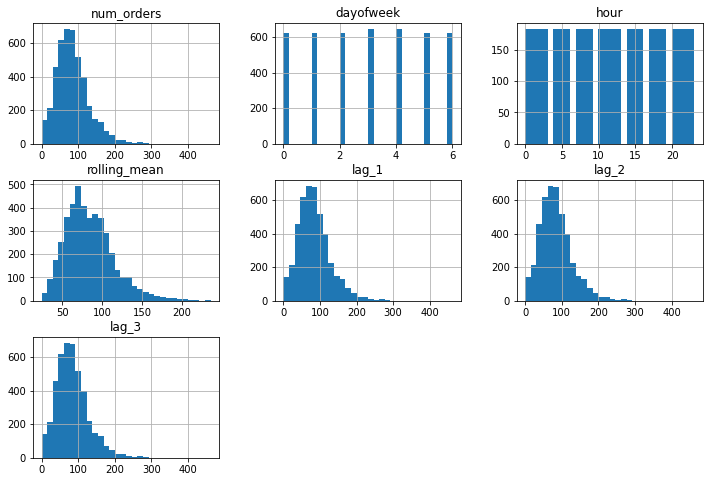

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
data.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Параметры признака",
    ylabel="Количество заказов, соотвествующих параметру",
)

In [29]:
print(train.shape)
print(test.shape)

(3974, 7)
(442, 7)


Проверим корректность деления на выборки

In [30]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [31]:
print(train.shape)
print(test.shape)

(3974, 7)
(442, 7)


In [32]:
train = train.dropna()
test = test.dropna()

In [33]:
X_train = train.drop(['num_orders'],axis = 1) # Переменные для обучающей выборки
y_train = train['num_orders'] 

X_test = test.drop(['num_orders'],axis = 1) # Переменные для тестовой выборки
y_test = test['num_orders'] 

### Случайный лес

In [34]:
%%time
model = RandomForestRegressor(random_state=rdm, n_estimators=100)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
RMSE_RF=rmse(y_test, predictions)
print("RMSE RF:",RMSE_RF)

RMSE RF: 48.80362156699335
CPU times: user 1.23 s, sys: 24.1 ms, total: 1.26 s
Wall time: 1.26 s


### Линейная регрессия

In [35]:
%%time
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
RMSE_LR = rmse(y_test, predictions)
print("RMSE LR:",RMSE_LR)

RMSE LR: 54.115855717365626
CPU times: user 12.3 ms, sys: 8.47 ms, total: 20.8 ms
Wall time: 21.6 ms


### Применение TimeSeriesSplit

Поскольку мы имеем дело  верменными рядами, то корректнее разделять датасет  помощью TimeSeriesSplit. Посмотрим как изменится результат работы модели Линейной регресси поссле применения такого деления. А также используем его для работы модели градиентного бустинга

In [36]:
cv = TimeSeriesSplit(n_splits=6)
print(cv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None)


### CatBoostRegressor

In [37]:
%%time
scoring_fit = 'neg_mean_squared_error'

cat_features = ['hour']

model_cat = CatBoostRegressor(cat_features=cat_features)
param_grid  = {'n_estimators':[50,100,150],
               'max_depth':[5,10],
}
gs = GridSearchCV (model_cat,param_grid,cv = cv,scoring = scoring_fit)
fitted_cat = gs.fit(X_train,y_train,cat_features=cat_features)

pred = fitted_cat.predict(X_test) 
def rmse(y, predictions):
    return (((y_test-pred)**2).mean())**0.5
rmse_cat = rmse(y_test, pred) 

Learning rate set to 0.427903
0:	learn: 23.7967484	total: 51.5ms	remaining: 2.52s
1:	learn: 20.9745311	total: 52.9ms	remaining: 1.27s
2:	learn: 19.0638636	total: 53.5ms	remaining: 838ms
3:	learn: 18.1791458	total: 54.3ms	remaining: 625ms
4:	learn: 17.3680551	total: 55.1ms	remaining: 496ms
5:	learn: 16.9243943	total: 55.8ms	remaining: 409ms
6:	learn: 16.7093405	total: 56.4ms	remaining: 346ms
7:	learn: 16.5173550	total: 57.1ms	remaining: 300ms
8:	learn: 16.4269888	total: 57.8ms	remaining: 263ms
9:	learn: 16.2707741	total: 58.4ms	remaining: 233ms
10:	learn: 16.0808180	total: 59ms	remaining: 209ms
11:	learn: 15.8600982	total: 59.6ms	remaining: 189ms
12:	learn: 15.6606468	total: 60.2ms	remaining: 171ms
13:	learn: 15.5497473	total: 60.8ms	remaining: 156ms
14:	learn: 15.4020430	total: 61.9ms	remaining: 144ms
15:	learn: 15.2969142	total: 62.8ms	remaining: 133ms
16:	learn: 15.1405730	total: 63.9ms	remaining: 124ms
17:	learn: 15.0591888	total: 64.6ms	remaining: 115ms
18:	learn: 14.9565676	total:

In [38]:
print ("rmse при работе модели catboost", rmse_cat)
print ("наилучшие параметры модели catboost", fitted_cat.best_params_)

rmse при работе модели catboost 44.961602243727164
наилучшие параметры модели catboost {'max_depth': 5, 'n_estimators': 150}


In [39]:
rmse_cat_test = (np.sqrt(mae(y_test, pred))) 
print(rmse_cat)

44.961602243727164


In [40]:
def score_func(X_train, prediction):
    return np.sqrt(mae(X_train, predictions, squared=Flase))

rmse = make_scorer(score_func, greater_is_better = False)

### Линейная регрессия после TimeSeriesSplit

In [41]:
model_lr = LinearRegression()
param_lr = {'fit_intercept':[True,False],'normalize':[True,False]}
model_lr_grid = GridSearchCV(model_lr,param_lr, cv=cv, scoring = 'neg_mean_squared_error')
model_lr_grid.fit(X_train,y_train)

MAE_LR = model_lr_grid.best_score_
RMSE_LR_TS = np.sqrt(abs(MAE_LR))

print("MAE LR:",model_lr_grid.best_score_)
print("RMSE LR:",RMSE_LR_TS)
print(model_lr_grid.best_params_)

MAE LR: -1073.3211624849866
RMSE LR: 32.76158058587813
{'fit_intercept': True, 'normalize': True}


scoring = 'neg_mean_squared_error'. Там заложена так, чтобы искать минимамльную ошибку. И в итоге возникает минус. Но на него можно не обращать внимание.

## Результаты работы моделей

In [44]:
result_models = pd.Series({"RMSE RF":RMSE_RF,"RMSE LR":RMSE_LR,'RMSE Catboost ':rmse_cat,"RMSE_LR_TS":RMSE_LR_TS})
result_models

RMSE RF           48.803622
RMSE LR           54.115856
RMSE Catboost     44.961602
RMSE_LR_TS        32.761581
dtype: float64

## Предсказание заказов такси

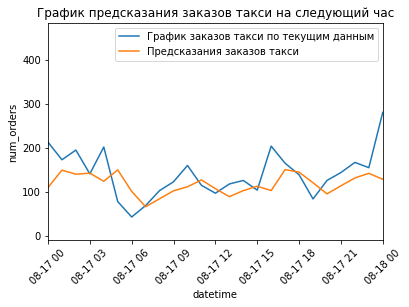

In [54]:
sns.lineplot(x=y_test.index,
                y = y_test, label = 'График заказов такси по текущим данным')
sns.lineplot(x=y_test.index,
                y = pred_lr_grid, label = 'Предсказания заказов такси')
plt.legend(loc = 'upper right')
plt.title ('График предсказания заказов такси на следующий час')
plt.xlim(pd.Timestamp('2018-08-17'), pd.Timestamp('2018-08-18'))
plt.xticks(rotation=45 )
plt.show()

### Общий вывод и результаты

Требование задания об RMSE менее 48 при работе модели выполенено в моделях градиентного бустсинга RMSE Catboost = 44.961602 и в модели лиеной регрессси после применения TimeSeriesSplit при разделении датасета и подборе  гиперпараметров в гридссерч RMSE_LR_TS = 32.761581. Результат работы Линейной регресии после TimeSeriesSplit показал наилучшие результаты.

Результы предскзааний -- падение количество заказов такси от 50 до 65 шт. на следующий час в августе 2018 года. 